Ali Al Kadhim and Harrison B. Prosper <br>
Department of Physics, Florida State University <br>
Date: 3 May 2022


In particle physics, the most important experiment is a counting experiment, represented by a Poisson probability model, where $N$ is the observed count and $\theta$ is a nuissance parameter, hence the probability model is $P(N|\theta) = \text{Poisson}(N,\theta)$.
where the most important parameter is the cross section $\sigma$, which is related to the mean event count $N = \sigma \mathcal{L} +b$. 


### For the two-parameter problem, $n=\theta+\nu$, and the probability model is given by

$$p(n,m|\theta, \nu) = \text{Poiss}(n, \theta+\nu)\text{Poiss}(m,\nu) =L(\theta, \nu)= \frac{e^{-(\theta+\nu)} (\theta+\nu)^n }{n !} \ \frac{e^{-\nu} \nu^m}{m !}$$

Where $\nu$ is the nuissance parameter, $\theta$ is the paramter of interest (for which we want to estimate upper limits). 

The standard procedure for removal of nuissance parameters is Bayesian marginalization, but in this study we adopt LFI with frequentest methods.

In this notebook we generate data comprising the quadruplets $(Z_i, \theta_i, \nu_i, N_i, M_i)$ where 

$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \textrm{ and } \\
Z & = I[ \lambda_{\textrm{gen}} \leq \lambda_D (D, \theta) ],
\end{align}
$

where the size of each of these samples is $B'$, $I$ is the indicator function, and $\lambda_D (D, \theta)= \lambda(N, M, \theta)$.

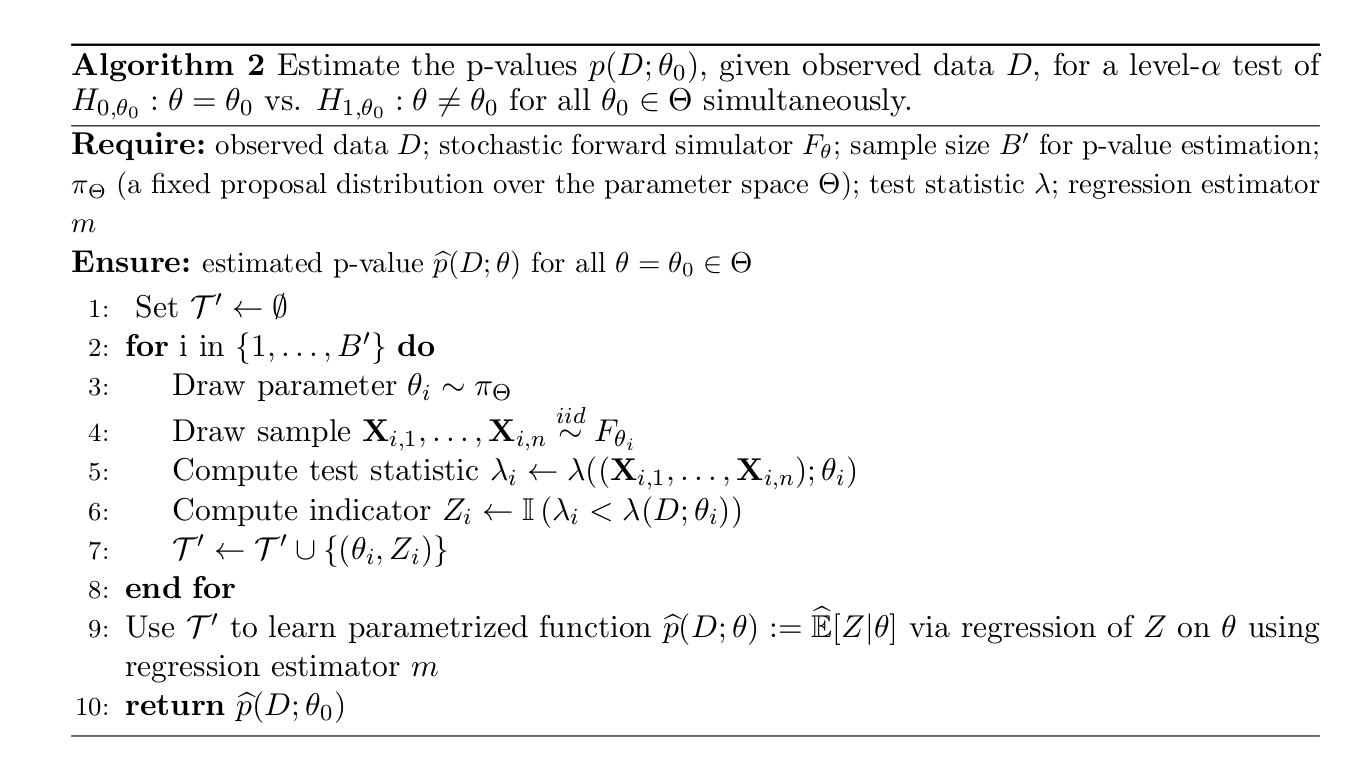

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mp
mp.rcParams['agg.path.chunksize'] = 10000
import matplotlib.pyplot as plt
# force inline plots
# %matplotlib inline
plt.style.use('seaborn-deep')
import torch.nn as nn
import copy
import pandas as pd
import sys
import os
# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set a seed to ensure reproducibility
# seed = 128
# rnd  = np.random.RandomState(seed)
#matplotlib configurations
def set_figsize(figsize=(3.5, 2.5)):  
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
    
    
def DR(s, theta):
    return sp.special.gammainc(s, theta)

def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)
from IPython.display import Image, display
algorithm2 = Image('../images/Algorithm2.jpg')
display(algorithm2)

# Generate Data:
In this notebook we assume that $\hat{\theta}$ is given by its MLE. We generate data of size $B'$ according to our probability model:

$$P(n,m|\theta, \nu) = L(\theta, \nu) = \frac{e^{-(\theta+\nu)} (\theta+\nu)^n }{n !} \ \frac{e^{-\nu} \nu^m}{m !}$$

Where $\nu$ is the nuissance parameter, $\theta$ is the paramter of interest.

Our test statistic will be:

$$ \lambda = -2 \log \frac{L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))}{L_{\text{prof}} (n, m, \hat{\theta}_{\text{MLE}}, \hat{\nu}(\theta))}$$

Where $L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))$ is the profiled likelihood. The maximum likelihood estimate of $\hat{\theta}$, 
$$\hat{\theta}_{\text{MLE}}=n-m$$, and

$$\log{p(n,m|\theta,\nu)} = -(\theta+\nu)+n\log{(\theta+\nu)|-\nu+m\log{\nu}} + \text{constants}$$
The MLE $\hat{\nu}(\theta)$ is attained by solving $\frac{\partial \log{p(n,m|\theta,\nu)}}{ \partial \nu} =0$ leading to 

$$\hat{\nu}(\theta)=\left(g+\sqrt{g^2 + 8 m \theta} \right)/4$$
where $g \equiv n+m-2 \theta$.

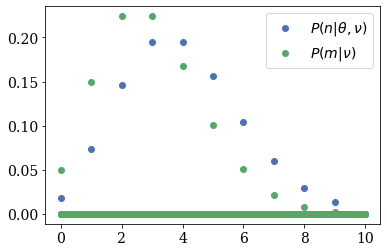

In [3]:
n, m = np.arange(0, 10, 0.01), np.arange(0, 10, 0.01)
theta, nu = 1, 3
Ln = st.poisson.pmf(n, mu = theta+nu)
Lm = st.poisson.pmf(m, mu = nu)

plt.scatter(n , Ln, label=r'$P(n|\theta, \nu)$')
plt.scatter(m, Lm, label=r'$P(m|\nu)$')
plt.legend()

Compute the profile likelihood $L_{\text{profile}} = p(n,m|\theta, \hat{\nu}(\theta) )=L_{\text{prof}}(n,m,\theta )$

In [2]:
k=1
def L_prof(n,m,theta):
    k=1
    k1 = k+1
    k2 = 0.5/k1
    g = n+m - k1*theta
    nu_hat = k2* (g+ np.sqrt(g*g +4*k1*m*theta))
    p1 = st.poisson.pmf(n, mu = theta + nu_hat)
    p2 = st.poisson.pmf(m, mu = k * nu_hat)
    
    return p1*p2

Compute $\hat{\theta}$
1. MLE: $\hat{\theta}(n,m) = n-m$
2. non-MLE: $\hat{\theta}(n,m)=n-m$ if $n>m$, else $0$

Again, in this notebook we use $\hat{\theta}_{\text{MLE}}=\hat{\theta}_{\text{MLE}}(n,m)$

In [3]:
def theta_hat(n,m, MLE=True):
    theta_hat = n-m
    
    if not MLE:
        theta_hat = theta_hat * (theta_hat > 0)
    return theta_hat

Compute 
$$ \lambda (\theta, n, m) = - 2 \log{\frac{p(n,m|\theta, \hat{\nu}(\theta) )}{ p(n,m|\hat{\theta}, \hat{\nu}(\theta) )}} = -2 \log{\frac{L_{\text{profile}} (\theta, \hat{\nu}(\theta))}{L_{\text{profile}} (\hat{\theta}(n,m), \hat{\nu}(\theta))}}$$

In [4]:
def lambda_test(theta, n, m, MLE=True):
    Ln = L_prof(n,m,theta)
    Ld = L_prof(n,m, theta_hat(n,m, MLE))
    lambda_  = -2*np.log(Ln/Ld)
    return lambda_

In [9]:
chi2_exp_size=40

def run_sim( theta, nu):
    """Sample n ~ Pois(theta+nu), m ~ Pois(nu), and compute lambda(theta, n, m)
    return (n, m, lambda_), where each are np arrays of length chi2_expo
    """
    n = st.poisson.rvs(theta+nu, size=chi2_exp_size)
    m = st.poisson.rvs(nu, size=chi2_exp_size)
    lambda_ = lambda_test(theta, n, m, MLE)
    return (n, m, lambda_)

def run_sims(points):
    """
    input: a tuple of (theta, nu)
    Run an entire simulation (that is, generate n and m from 
    run_sim above, and calculate lambda) for each point, where 
    """
    lambda_results=[]

    for p in points:
        theta, nu = p
        n, m, lambda_ = run_sim(theta, nu)
        lambda_results.append((n, m, lambda_, theta, nu))
        print( '(theta, nu) =  (%.f, %.f) ' % (theta, nu) )
        print('\t \t with associated (n, m, lambda) = (%.f, %.f, %.f)' % (n, m, lambda_) )
    return lambda_results


def plot_one(lambda_, theta, nu, ax):
    """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), 
    for a given (fixed) theta and nu.
    Also, plot the actual CDF of a chi^2 distribution with 1 free parameter 
    (since only theta is left after we profile nu) """
    ftsize = 16
    xmin= 0
    xmax= 10
    ymin= 0
    ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax.set_xlim(x_range)
    ax.set_ylim(y_range)
    ax.set_xlabel(r'$\lambda (\theta, n, m, \hat{\nu}(\theta))$',fontsize=ftsize)
    ax.set_ylabel(r'cdf$(\lambda)$', fontsize=ftsize)
    ax.hist(lambda_, bins=5*xmax, range=x_range,
    color=(0.8,0.8,0.9),
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black', label=r'CDF$(\lambda)$')
    
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.cdf(x, 1)
    ax.plot(x, y, color='blue',
    linewidth=2, label=r'CDF$(\chi^2_1)$')
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid/2
    ypos = ymin + ywid*2
    ax.text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
    ax.legend(loc='upper right',fontsize=10)
    
def plot_all(results, fgsize=(10,6)):
    plt.figure(figsize=fgsize)
    fig, ax = plt.subplots(2, 3, figsize=fgsize)
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.2)
    ax = ax.flatten()
    
    for i, result in enumerate(results):
        n, m, lambda_, theta, nu = result
        plot_one(lambda_, theta, nu, ax[i])
    for j in range(len(results), len(ax)):
        ax[j].set_visible(False)
        
    plt.tight_layout()
    plt.savefig('calibration_lambda.png')
    plt.show()
    

In [11]:
MLE=True
#generate (theta, nu) points
points = [(theta, nu) for theta, nu in 
          zip(np.random.randint(low=1,high=4,size=6), 
              np.random.randint(low=0,high=4,size=6))]

results = run_sims(points)


(theta, nu) =  (2, 1) 
(theta, nu) =  (3, 2) 
(theta, nu) =  (1, 3) 
(theta, nu) =  (1, 0) 
(theta, nu) =  (2, 3) 
(theta, nu) =  (2, 3) 


In [24]:
n, m, lambda_, theta, nu =results[1]
print
print(f'first :result = results[1] =  (n, m, lambda, theta, nu) =  (  \n {n}, \n {m}, \n {lambda_}, \n {theta}, \n {nu})' )

first :result = results[1] =  (n, m, theta, nu) =  (  
 [ 3 10  2  7  7  7  8  5  5  4  9  3  8  7  8  6  2  5  6  2  4  6  5  3
  5  5  3  6  6  3  6  3  1  2  9  3  7  9  3  3], 
 [2 0 2 4 0 4 1 2 4 2 5 0 1 2 1 0 3 6 1 4 2 0 2 0 3 4 1 3 2 3 2 1 4 4 0 5 1
 1 1 0], 
 [ 0.71793764  7.86294361  1.86125037 -0.          3.70406053 -0.
  2.11551488 -0.          0.42779025  0.1590528   0.07223789 -0.
  2.11551488  0.47383495  2.11551488  2.31776617  2.75601746  1.39753379
  0.64125465  3.71177679  0.1590528   2.31776617 -0.         -0.
  0.12163959  0.42779025  0.22705913 -0.          0.12957946  1.35592294
  0.12957946  0.22705913  6.28525086  3.71177679  6.47664925  2.90339061
  1.30622911  3.02906505  0.22705913 -0.        ], 
 3, 
 2)


In [22]:
# def plot_likelihood_heatmap(size):
    
    
#     theta, nu = np.random.randint(low=0,high=20,size=size), np.random.randint(low=0,high=20,size=size)

#     n = st.poisson.rvs(theta+nu, size=size)
#     m = st.poisson.rvs(nu, size=size)
    
#     L_theta_hat_nu_hat_l = []
#     theta_hat_l =[]
#     for ni, mi in zip(n, m):
#         theta_hat_l.append(theta_hat(n,m, MLE))
        
#         L_theta_hat_nu_hat_l.append(L_prof(n,m, theta_hat(n,m, MLE)))
    
#     L_theta_hat_nu_hat_l = np.array(L_theta_hat_nu_hat_l)
#     theta_hat_l = np.array(theta_hat_l)
#     fig, ax0 = plt.subplots()
    
#     X,Y = np.meshgrid(theta, nu)
#     im0 = ax0.pcolormesh(X, Y, L_theta_hat_nu_hat_l, cmap='bwr')
#     cbar = fig.colorbar(im0, ax=ax0)
#     ax0.set_title(r'$L(\hat{\theta}, \hat{\nu})$')
#     plt.xlabel(r'$\theta$')
#     plt.ylabel(r'$\nu$')
    
#     plt.show()
    

In [23]:
# plot_likelihood_heatmap(1000)

<Figure size 720x432 with 0 Axes>

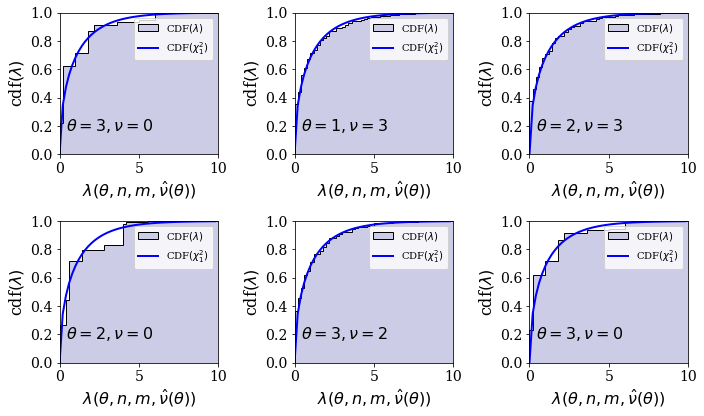

In [9]:
plot_all(results)

Looks like the CDF of a $\chi^2_{k=1}$, as expected!

In [25]:
Bprime    = 10000000
thetaMin, thetaMax =  0, 10
nuMin, nuMax = 0, 10
Mmin, Mmax =  0 , 10
Nmin, Nmax =  0,10
MLE=True
def generate_training_data(Bprime, save_data=False):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    
    #sample our observed counts (N,M), which take the place of D
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    print('n=', n)
    print('m=', m)
    print('N=', N)
    print('M=', M)
    lambda_gen = lambda_test(theta, n, m, MLE)
    print('lambda_gen= ', lambda_gen)
    lambda_D = lambda_test(theta, N, M, MLE)
    print('lambda_D= ', lambda_D)
    #if lambda_gen <= lambda_D: Z=1, else Z=0
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    
    data_2_param = {'Z' : Z, 'theta' : theta, 'nu': nu, 'N':N, 'M':M}

    data_2_param = pd.DataFrame.from_dict(data_2_param)
    if save_data:
        data_2_param.to_csv('data/two_parameters_N_M_Uniformly_sampled_1M.csv')

    print(data_2_param.head())
    return data_2_param

In [26]:
data_2_param=generate_training_data(Bprime,save_data=True)

n= [14 17 18 ...  9 12 14]
m= [ 5  7  6 ... 10  6  1]
N= [0 5 0 ... 6 1 4]
M= [4 5 7 ... 2 7 2]
lambda_gen=  [1.62725227e-02 1.25047200e-03 4.94148788e-01 ... 1.23488789e-01
 2.88543101e-01 4.35096597e+00]
lambda_D=  [22.43804702  7.33547452 26.95136639 ...  1.58864038 19.38963149
  1.94748917]


FileNotFoundError: [Errno 2] No such file or directory: 'data/two_parameters_N_M_Uniformly_sampled_1M.csv'

In [27]:
data_2_param=pd.read_csv('TWO_PARAMETERS_TRAINING_DATA_1M.csv')
data_2_param.head()

,Unnamed: 0,Z,theta,nu,N,M
0,0,1,19.597712,10.387874,5,6
1,1,1,13.316589,0.052172,1,6
2,2,1,9.565929,2.031794,3,6
3,3,1,19.145463,8.600285,9,3
4,4,0,7.994914,7.861142,8,2


In [28]:
d2=data_2_param[['theta','nu','N','M']]
d2

,theta,nu,N,M
0,19.597712,10.387874,5,6
1,13.316589,0.052172,1,6
2,9.565929,2.031794,3,6
3,19.145463,8.600285,9,3
4,7.994914,7.861142,8,2
...,...,...,...,...
199995,1.176367,17.766815,7,7
199996,12.543278,10.465703,6,5
199997,7.309926,0.438587,5,7
199998,6.197566,7.850007,5,9


In [29]:
np.array(d2).shape

(200000, 4)

In [30]:
len(data_2_param[:1000])

1000

In [31]:
len(data_2_param[:1000].Z)

1000

In [32]:
# np.sum(data_2_param.Z)/len(data_2_param.Z)

Plot the weighted/unweighted histogram

In [33]:
def plot_weighted_hist(data_df):
    #we can select which M, N by doing select= data_df.M = M
    data_df = pd.read_csv(data_df)
    fig, ax = plt.subplots(1,1, figsize=(7,7))
    fig.tight_layout()
    hist_counts_theta_w, b_theta_w = np.histogram(data_df.theta, weights=np.array(data_df.Z), bins=100)
    hist_counts_theta_uw, b_theta_uw = np.histogram(data_df.theta, bins=100)
    hist_counts_theta = hist_counts_theta_w/hist_counts_theta_uw
    #CLEARLY IT DOESN'T WORK FOR NU
    # hist_counts_nu_w, b_nu_w = np.histogram(data_df.nu, weights=np.array(data_df.Z), bins=100)
    # hist_counts_nu_uw, b_nu_uw = np.histogram(data_df.nu, bins=100)
    # hist_counts_nu = hist_counts_nu_w/hist_counts_nu_uw
    
    theta_bin_centers = (b_theta_w[1:]+b_theta_w[:-1])/2
    # nu_bin_centers = (b_nu_w[1:]+b_nu_w[:-1])/2
    ax.plot(theta_bin_centers, hist_counts_theta, label=r'Weighted Hist/Unweighted Hist for $\theta$')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$E[\theta]$')
    ax.legend()
    # ax[1].plot(nu_bin_centers, hist_counts_nu, label=r'Weighted Hist/Unweighted Hist for $\nu$')
    # ax[1].set_xlabel(r'$\nu$')
    # ax[1].legend()

-------------------------------
# ML Parts

In [34]:
# Fraction of the data assigned as test data
fraction = 1/102
inputs = ['theta', 'nu', 'N', 'M','Z']
data = data_2_param[inputs]
# Split data into a part for training and a part for testing
train_data, test_data = train_test_split(data, 
                                         test_size=fraction)

# Split the training data into a part for training (fitting) and
# a part for validating the training.
fraction = 1/101
train_data, valid_data = train_test_split(train_data, 
                                          test_size=fraction)

# reset the indices in the dataframes and drop the old ones
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data  = test_data.reset_index(drop=True)

print('train set size:        %6d' % train_data.shape[0])
print('validation set size:   %6d' % valid_data.shape[0])
print('test set size:         %6d' % test_data.shape[0])

train_data[:5]

train set size:        196078
validation set size:     1961
test set size:           1961


,theta,nu,N,M,Z
0,8.513013,18.298027,5,8,1
1,10.942525,16.926142,9,4,1
2,13.127385,19.545597,8,3,1
3,9.808208,11.473414,2,3,1
4,12.174031,18.878225,9,4,1


### Do some scaling here

In [36]:
features=['theta', 'nu', 'N', 'M']

def split_t_x(df, inp=features):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df['Z'])
    x = np.array(df[inp])
    return (t, x)
train_t, train_x = split_t_x(train_data)
valid_t, valid_x = split_t_x(valid_data)
test_t,  test_x  = split_t_x(test_data)
train_t, train_x

(array([1, 1, 1, ..., 1, 1, 0]),
 array([[ 8.51301315, 18.29802748,  5.        ,  8.        ],
        [10.94252524, 16.92614223,  9.        ,  4.        ],
        [13.12738468, 19.54559701,  8.        ,  3.        ],
        ...,
        [10.38214093, 11.97904342,  7.        ,  7.        ],
        [12.33491562,  7.5616589 ,  7.        ,  0.        ],
        [ 6.29614801,  3.37848553,  6.        ,  5.        ]]))

In [37]:
def get_batch(x, t, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    batch_t = t[rows]
    return (batch_x, batch_t)

def average_loss(f, t):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t)

In [38]:
def train(model, optimizer, avloss, getbatch,
          train_x, train_t, 
          valid_x, valid_t,
          batch_size, 
          n_iterations, traces, 
          step=50):
    
    # to keep track of average losses
    xx, yy_t, yy_v = traces
    
    n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = getbatch(train_x, train_t, batch_size)
        
        # convert the numpy arrays batch_x and batch_t to tensor 
        # types. The PyTorch tensor type is the magic that permits 
        # automatic differentiation with respect to parameters. 
        # However, since we do not need to take the derivatives
        # with respect to x and t, we disable this feature
        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            
            acc_t = validate(model, avloss, train_x[:n], train_t[:n]) 
            acc_v = validate(model, avloss, valid_x[:n], valid_t[:n])

            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v))
            else:
                xx.append(xx[-1] + step)
                print("\r%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], acc_t, acc_v), end='')
                
            yy_t.append(acc_t)
            yy_v.append(acc_v)
    print()      
    return (xx, yy_t, yy_v)

In [72]:
def plot_average_loss(traces):
    
    xx, yy_t, yy_v = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')

    ax.set_xlabel('Iterations', fontsize=FONTSIZE)
    ax.set_ylabel('average loss', fontsize=FONTSIZE)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

In [76]:
import torch
import torch.nn as nn

class Model(nn.Module):
    
    def __init__(self, n_inputs=4, n_nodes=20, n_layers=50):

        # call constructor of base (or super, or parent) class
        super(Model, self).__init__()

        self.layers = []
        
        # create input layer
        self.layer0 = nn.Linear(n_inputs, n_nodes)
        self.layers.append(self.layer0)

        # create "hidden" layers
        for l in range(1, n_layers):
            cmd = 'self.layer%d = nn.Linear(%d, %d)' % \
            (l, n_nodes, n_nodes)
            exec(cmd)
            cmd = 'self.layers.append(self.layer%d)' % l
            exec(cmd)
          
        # create output layer
        cmd = 'self.layer%d = nn.Linear(%d, 1)' % (n_layers, n_nodes)
        exec(cmd)
        cmd = 'self.layers.append(self.layer%d)' % n_layers
        exec(cmd)

    # define (required) method to compute output of network
    def forward(self, x):
        y = x
        for layer in self.layers[:-1]:
            y = layer(y)
            y = torch.relu(y)
        y = self.layers[-1](y)
        y = torch.sigmoid(y)
        return y

In [77]:
model = Model()
# print(model)

In [38]:
#print all model parameters and layers
print([(name, param.shape) for name, param in model.named_parameters()])

[('layer0.weight', torch.Size([20, 4])), ('layer0.bias', torch.Size([20])), ('layer1.weight', torch.Size([20, 20])), ('layer1.bias', torch.Size([20])), ('layer2.weight', torch.Size([20, 20])), ('layer2.bias', torch.Size([20])), ('layer3.weight', torch.Size([20, 20])), ('layer3.bias', torch.Size([20])), ('layer4.weight', torch.Size([20, 20])), ('layer4.bias', torch.Size([20])), ('layer5.weight', torch.Size([20, 20])), ('layer5.bias', torch.Size([20])), ('layer6.weight', torch.Size([20, 20])), ('layer6.bias', torch.Size([20])), ('layer7.weight', torch.Size([20, 20])), ('layer7.bias', torch.Size([20])), ('layer8.weight', torch.Size([20, 20])), ('layer8.bias', torch.Size([20])), ('layer9.weight', torch.Size([20, 20])), ('layer9.bias', torch.Size([20])), ('layer10.weight', torch.Size([20, 20])), ('layer10.bias', torch.Size([20])), ('layer11.weight', torch.Size([20, 20])), ('layer11.bias', torch.Size([20])), ('layer12.weight', torch.Size([20, 20])), ('layer12.bias', torch.Size([20])), ('laye

In [78]:
learning_rate = 1.e-3
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 

traces = ([], [], [])
traces_step = 10

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.256648	  0.256358
       490	  0.105119	  0.118119
Iteration vs average loss
 iteration	 train-set	 valid-set
     10490	  0.105092	  0.117839


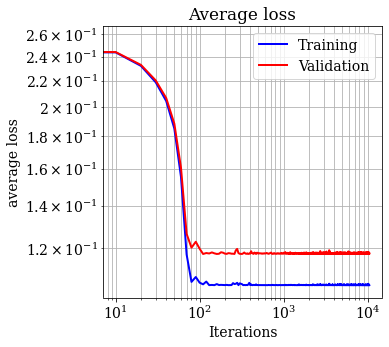

In [79]:
n_batch       = 50
n_iterations  = 500

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

n_batch       = 500
n_iterations  = 10000

traces = train(model, optimizer, average_loss,
               get_batch,
               train_x, train_t, 
               valid_x, valid_t,
               n_batch, 
               n_iterations,
               traces,
               step=traces_step)

plot_average_loss(traces)

Save trained model

In [62]:
torch.save(model, 'Regressor_TwoParams_theta_nu_m_n.pth')
# model.parameters

In [63]:
model = torch.load('Regressor_TwoParams_theta_nu_m_n.pth');# model.parameters

# Inference, and Comparing $\hat{p}(N,M,\theta,\nu)$ to caluclated p-value and histogrammed expectation value

What we want to approximate is the following:

$$P(\lambda_{\text{gen}} < \lambda_D)$$

### Interlude: Calculation of exact p-values


In [55]:
inputs = ['theta', 'nu', 'N', 'M']#input features (X)
data_df='data/two_parameters_N_M_Uniformly_sampled_1M.csv'
df = pd.read_csv(data_df)
Input_features = data_2_param
############ ML inference part
with torch.no_grad():
    model.eval()

    X = torch.Tensor(Input_features.values)
    phat = model(X)
    phat = phat.detach().flatten()
    # phat=phat.numpy()
    PHAT = phat.view(-1).numpy()
    print(phat.flatten().shape)
# plt.hist(phat)
# ax.plot(theta_bin_centers, phat,label='phat')

torch.Size([1000000])


In [89]:
# th=np.array(df.theta).flatten()
# plot_weighted_hist(data_df)

In [90]:
# inference_df.csvplt.hist(PHAT.flatten(), label=r'$\hat{p}=\hat{E}[Z|\theta]$', density=True)
# plt.hist(df.Z, label=r'Exact $E[Z]=P(\lambda_{\tinference_df.csvext{gen}} \le \lambda_{\text{Obs}})$', density=True); plt.legend()

In [91]:
# chi2_exp_size=4000

# def run_sim( theta, nu):
#     """Sample n ~ Pois(theta+nu), m ~ Pois(nu), and compute lambda(theta, n, m)"""
#     n = st.poisson.rvs(theta+nu, size=chi2_exp_size)
#     m = st.poisson.rvs(nu, size=chi2_exp_size)
#     lambda_ = lambda_test(theta, n, m, MLE)
#     return (n, m, lambda_)

# def run_sims(points):
#     """Run an entire simulation (that is, generate n and m from run_sim above, and calculate lambda) for each point, where a point is a tuple of (theta, nu)"""
#     lambda_results=[]

#     for p in points:
#         theta, nu = p
#         n, m, lambda_ = run_sim(theta, nu)
#         lambda_results.append((n, m, lambda_, theta, nu))
#         print((theta, nu))
#     return lambda_results


# def plot_one(lambda_, theta, nu, ax):
#     """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), for a given (fixed) theta and nu.
#     Also, plot the actual CDF of a chi^2 distribution with 1 free parameter (since only theta is left after we profile nu) """
#     ftsize = 16
#     xmin= 0
#     xmax= 10
#     ymin= 0
#     ymax= 1
#     x_range = (xmin, xmax)
#     y_range = (ymin, ymax)
#     ax.set_xlim(x_range)
#     ax.set_ylim(y_range)
#     ax.set_xlabel(r'$\lambda (\theta, n, m, \hat{\nu}(\theta))$',fontsize=ftsize)
#     ax.set_ylabel(r'cdf$(\lambda)$', fontsize=ftsize)
#     ax.hist(lambda_, bins=5*xmax, range=x_range,
#     color=(0.8,0.8,0.9),
#     density=True, cumulative=True,
#     histtype='stepfilled', edgecolor='black')
    
#     x = np.arange(0, xmax, 0.2)
#     y = st.chi2.cdf(x, 1)
#     ax.plot(x, y, color='blue',
#     linewidth=2)
#     # annotate
#     xwid = (xmax-xmin)/12
#     ywid = (ymax-ymin)/12
#     xpos = xmin + xwid/2
#     ypos = ymin + ywid*2
#     ax.text(xpos, ypos,
#     r'$ \theta = %d, \nu = %d$' % (theta, nu),
#     fontsize=ftsize)
    
# def plot_all(results, fgsize=(10,6)):
#     plt.figure(figsize=fgsize)
#     fig, ax = plt.subplots(2, 3, figsize=fgsize)
#     plt.subplots_adjust(hspace=0.01)
#     plt.subplots_adjust(wspace=0.2)
#     ax = ax.flatten()
    
#     for i, result in enumerate(results):
#         n, m, lambda_, theta, nu = result
#         plot_one(lambda_, theta, nu, ax[i])
#     for j in range(len(results), len(ax)):
#         ax[j].set_visible(False)
        
#     plt.tight_layout()
#     plt.show()
    

In [60]:
data_df = pd.read_csv(data_df)
inference_df = data_df
inference_df['phat'] = PHAT
cols = ['Z', 'theta', 'nu', 'N', 'M', 'phat']
inference_df=inference_df[cols]
inference_df.head()

,Z,theta,nu,N,M,phat
0,1,29.014641,37.674462,9,22,1.000000
1,1,5.216490,36.416669,5,21,0.999976
2,1,19.011076,13.583114,15,2,0.824368
3,1,2.730501,5.468507,1,12,0.999671
4,1,11.254103,1.051720,15,22,0.998790


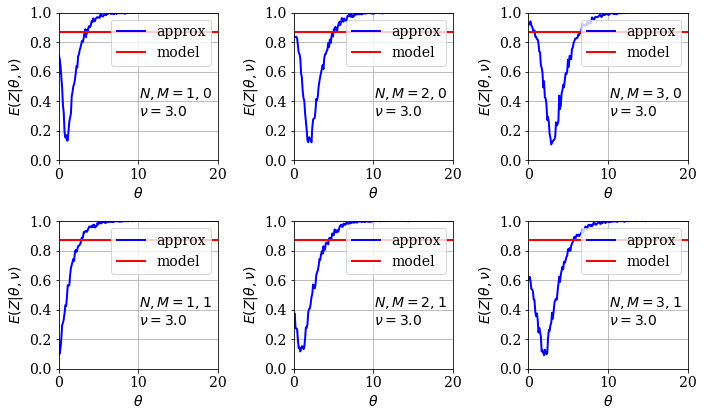

In [80]:
XMIN  = 0
XMAX  = 20
XBINS = 200
NU    = 3#set
D     = [(1, 0), (2, 0), (3, 0), 
         (1, 1), (2, 1), (3, 1)]#pairs of (N,M)
import LFIutil as lfi

def hist_data(nu, N, M,
              xbins=XBINS,
              xmin=XMIN, 
              xmax=XMAX,
              mle=MLE,
              Ndata=100000):

    theta = st.uniform.rvs(xmin, xmax, size=Ndata)
    n = st.poisson.rvs(theta + nu)
    m = st.poisson.rvs(nu, size=Ndata)
    Z = (lfi.t2(theta, n, m, mle) < 
         lfi.t2(theta, N, M, mle)).astype(np.int32)

    xrange = (xmin, xmax)

    # weighted histogram   (count the number of ones per bin)
    y1, bb = np.histogram(theta, 
                          bins=xbins, 
                          range=xrange, 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    yt, _ = np.histogram(theta, 
                         bins=xbins, 
                         range=xrange)

    y =  y1 / yt    
    
    return y, bb

def plot_data(nu, D, 
              func=None,
              xbins=XBINS,
              xmin=XMIN, 
              xmax=XMAX,
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        
        y, bb = hist_data(nu, N, M)
        
        ax[j].set_xlim(xmin, xmax)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j].plot(x, y, 'b', lw=2, label='approx')
        
        if func:
            p, _ = func(nu, N, M)
            ax[j].plot(x, p, 'r', lw=2, label='model')
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   fontsize=FONTSIZE) 

        ax[j].text(10.1, 0.30, r'$\nu = %5.1f$' % nu, 
                   fontsize=FONTSIZE) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    # plt.savefig(gfile)
    plt.show()

def usemodel(nu, N, M,
             xbins=XBINS,
             xmin=XMIN,
             xmax=XMAX):
    
    xstep = (xmax-xmin) / xbins
    bb    = np.arange(xmin, xmax+xstep, xstep)
    X     = (bb[1:] + bb[:-1])/2
    X     = torch.Tensor([[x, nu, N, M] for x in X])
    
    model.eval()
    return model(X).detach().numpy(), bb

plot_data(NU, D, 
          func=usemodel)